# Mean squared error

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile,f_classif
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import statsmodels.api as sm
from scipy.stats import shapiro, probplot
from statsmodels.graphics.tsaplots import plot_acf

Best hyperparameters: {'svr__gamma': 0.0005, 'svr__epsilon': 0.0005, 'svr__C': 1000, 'select__k': 3}
Mean squared error: -0.05509100663933464
course_ML: False, p-value: 0.4232931608582372
course_retrieval: False, p-value: 0.47108119845709884
course_statistics: True, p-value: 0.005896936252828015
course_databases: False, p-value: 0.41943153221865626
gender: False, p-value: 0.4958642029820335
ChatGPT: False, p-value: 0.10259798368659791
age: False, p-value: 0.7650863729065188
students_in_room: False, p-value: 0.09706370476471446
prev_answer_stand: True, p-value: 0.010789003246906658
sports_per_week: True, p-value: 2.9824427791548697e-05
Test set mean squared error: 1168.8875654965857
Test set mean absolute error: 29.585729087784497
Test set R-squared score: -0.09377208419093663
95% confidence interval for test set predictions: [38.648841150212206, 56.40033917765665]
Shapiro-Wilk test for normality of residuals:
Statistic: 0.9634991884231567
p-value: 0.06592673808336258
The residuals are 

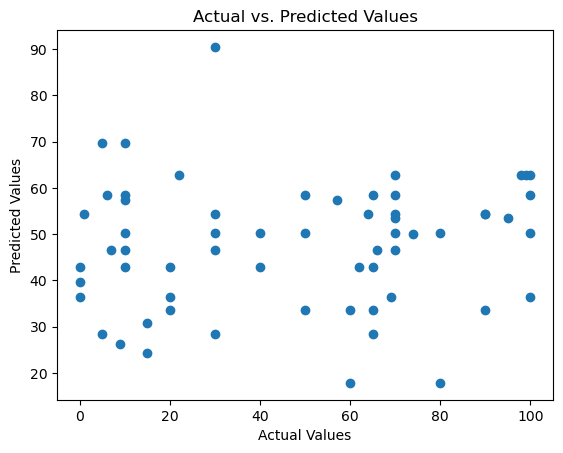

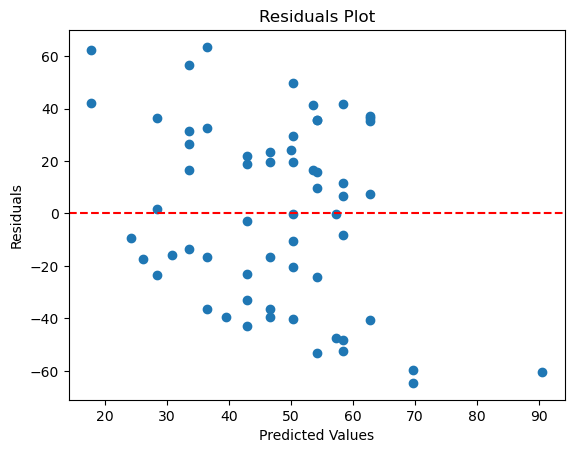

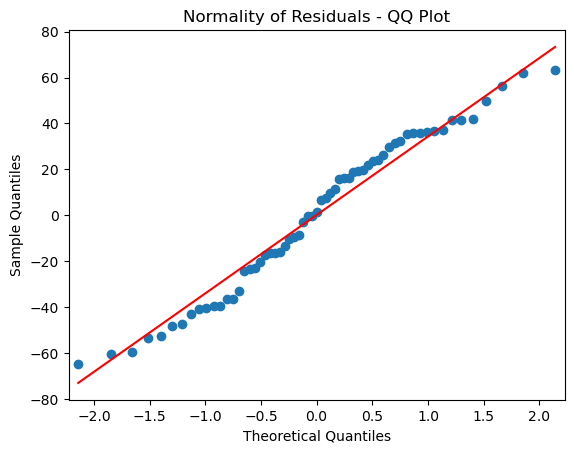

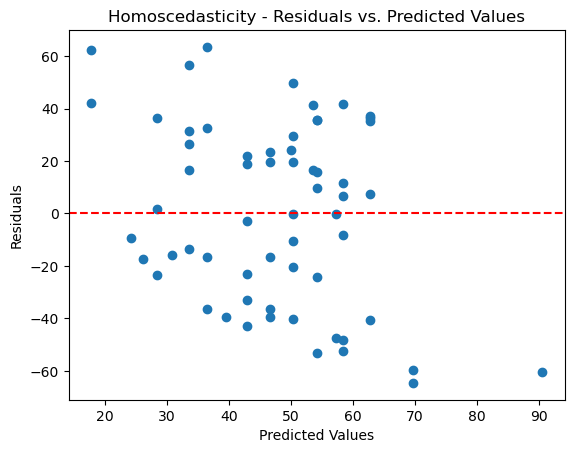

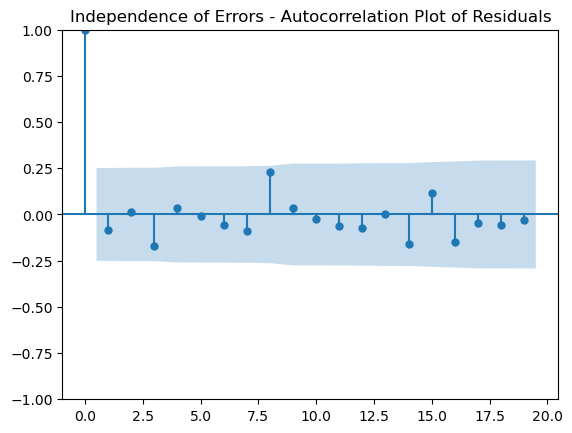

95% confidence interval for MSE: [ 889.81876614 1455.90476385]
95% confidence interval for MAE: [25.19524922 33.97548136]
95% confidence interval for R2: [-0.39300436  0.12952999]


In [76]:
# Load the dataset
data = pd.read_csv('new_data_fill_missing_linear&mode.csv')
data = data.drop(['programme',"Tijdstempel",'random_number','good_day_(1)',
                  'good_day_(2)','birthday','bed_time'], axis=1)

# Separate target variable and feature variables
target = data['stress_level']
data = data.drop(['stress_level'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# # Define column transformer to handle numerical features
# # Replace 'num_features' with the list of column names that represent numerical features in your dataset
cat_features = X_train[['course_ML', 'course_retrieval', 'course_statistics', 'course_databases', 'gender', 'ChatGPT', 'prev_answer_stand']]
scaler = MinMaxScaler()
cat_features = scaler.fit_transform(cat_features)
cat_features = scaler.transform(cat_features)

num_features = X_train[['sports_per_week', 'students_in_room']]

scaler = MinMaxScaler()
num_features = scaler.fit_transform(num_features)
num_features = scaler.transform(num_features)
# Split the dataset into training and testing sets

# # Scale the features


# Define the hyperparameters to be tuned
param_distributions = {
        'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
            'svr__gamma': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
     'select__k': [2, 3, 4]  # select the best 2, 3, or 4 features
}

# Scoring function for numerical features
score_func_num = f_regression
# Scoring function for categorical features
score_func_cat = f_classif
# Create SelectPercentile object for numerical features
select_num = SelectKBest(score_func=score_func_num,k=2)
# Create SelectPercentile object for categorical features
select_cat = SelectKBest(score_func=score_func_cat,k=3)
# Fit and transform numerical features
X_num_selected = select_num.fit_transform(num_features, y_train)
# Fit and transform categorical features
X_cat_selected = select_cat.fit_transform(cat_features, y_train)
# Concatenate or combine the selected features from both numerical and categorical features as needed
X_selected = np.concatenate((X_num_selected, X_cat_selected), axis=1)
# Create a pipeline to select the best features and train the SVR model
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_regression, k=3)),
    ('svr', SVR())
])

# Perform a randomized search to find the best hyperparameters
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42)
randomized_search.fit(X_train, y_train)


# Print the best hyperparameters and their corresponding MSE score
print("Best hyperparameters:", randomized_search.best_params_)
print("Mean squared error:", -randomized_search.best_score_)

# Print the selected features and their p-values
selected_features = randomized_search.best_estimator_.named_steps['select'].get_support()
p_values = randomized_search.best_estimator_.named_steps['select'].pvalues_
feature_names = data.columns
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {selected_features[i]}, p-value: {p_values[i]}")

# Evaluate the performance on the test set using the best hyperparameters
y_pred = randomized_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test set mean squared error:", mse)
print("Test set mean absolute error:", mae)
print("Test set R-squared score:", r2)

# Calculate the confidence interval for the test set
n = len(y_test)
k = randomized_search.best_estimator_.named_steps['select'].k
y_mean = np.mean(y_test)
t_value = 1.96 # t-value for 95% confidence interval
y_pred_std = np.sqrt(mse)
ci_half_width = t_value * y_pred_std / np.sqrt(n-k-1)
ci_lower = y_mean - ci_half_width
ci_upper = y_mean + ci_half_width
print(f"95% confidence interval for test set predictions: [{ci_lower}, {ci_upper}]")

# # Plot the residuals
residuals = y_test - y_pred

# Check if the residuals are normally distributed
stat, p = shapiro(residuals)
print("Shapiro-Wilk test for normality of residuals:")
print("Statistic:", stat)
print("p-value:", p)
if p > 0.05:
    print("The residuals are likely normally distributed.")
else:
    print("The residuals are not normally distributed.")

# Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residuals plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Normality of residuals - QQ plot
sm.qqplot(residuals, line='s')
plt.title('Normality of Residuals - QQ Plot')
plt.show()

# Homoscedasticity - Residuals vs. Predicted Values plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity - Residuals vs. Predicted Values')
plt.show()

# Independence of errors - Autocorrelation plot of residuals

plot_acf(residuals, lags=19)
plt.title('Independence of Errors - Autocorrelation Plot of Residuals')
plt.show()


from sklearn.utils import resample

# Define function to calculate R-squared, MSE, and MAE
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Perform bootstrapping to calculate confidence intervals
n_bootstraps = 1000 # Number of bootstraps
mse_scores = []
mae_scores = []
r2_scores = []
for i in range(n_bootstraps):
    # Bootstrap the test set
    X_test_boot, y_test_boot = resample(X_test, y_test, random_state=i)
    
    # Make predictions on bootstrapped test set
    y_pred_boot = randomized_search.predict(X_test_boot)
    
    # Calculate metrics on bootstrapped test set
    mse_boot, mae_boot, r2_boot = calculate_metrics(y_test_boot, y_pred_boot)
    
    # Append scores to lists
    mse_scores.append(mse_boot)
    mae_scores.append(mae_boot)
    r2_scores.append(r2_boot)

# Calculate confidence intervals
alpha = 0.05 # Significance level
mse_ci = np.percentile(mse_scores, q=[alpha/2*100, (1-alpha/2)*100])
mae_ci = np.percentile(mae_scores, q=[alpha/2*100, (1-alpha/2)*100])
r2_ci = np.percentile(r2_scores, q=[alpha/2*100, (1-alpha/2)*100])

# Print confidence intervals
print("95% confidence interval for MSE:", mse_ci)
print("95% confidence interval for MAE:", mae_ci)
print("95% confidence interval for R2:", r2_ci)

# mean_absolute_error

Best hyperparameters: {'svr__gamma': 0.0005, 'svr__epsilon': 0.0005, 'svr__C': 1000, 'select__k': 3}
Mean absolute error: -0.05509100663933464
course_ML: False, p-value: 0.4232931608582372
course_retrieval: False, p-value: 0.47108119845709884
course_statistics: True, p-value: 0.005896936252828015
course_databases: False, p-value: 0.41943153221865626
gender: False, p-value: 0.4958642029820335
ChatGPT: False, p-value: 0.10259798368659791
age: False, p-value: 0.7650863729065188
students_in_room: False, p-value: 0.09706370476471446
prev_answer_stand: True, p-value: 0.010789003246906658
sports_per_week: True, p-value: 2.9824427791548697e-05
Test set mean absolute error: 29.585729087784497
Test set R-squared score: -0.09377208419093663
95% confidence interval for test set predictions: [46.11250860434202, 48.936671723526835]
Shapiro-Wilk test for normality of residuals:
Statistic: 0.9634991884231567
p-value: 0.06592673808336258
The residuals are likely normally distributed.


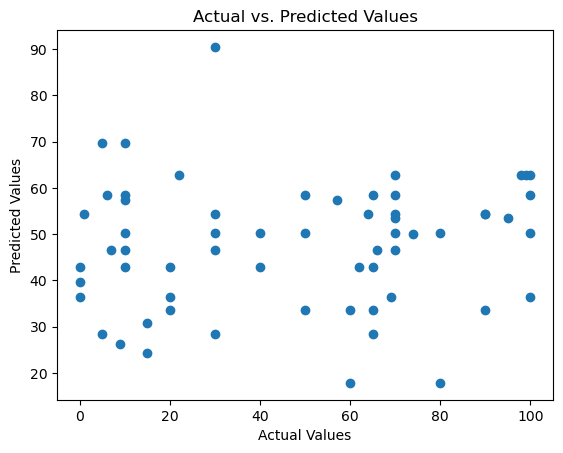

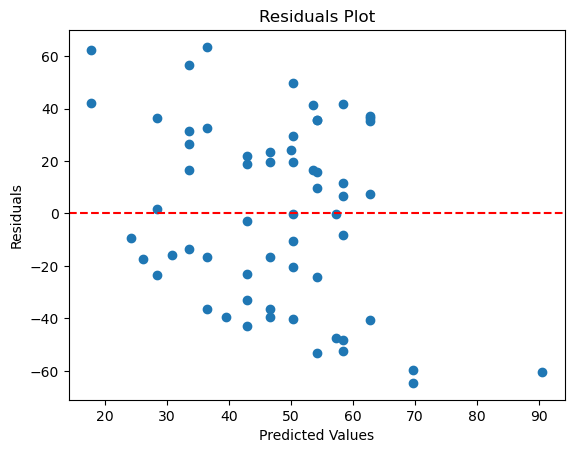

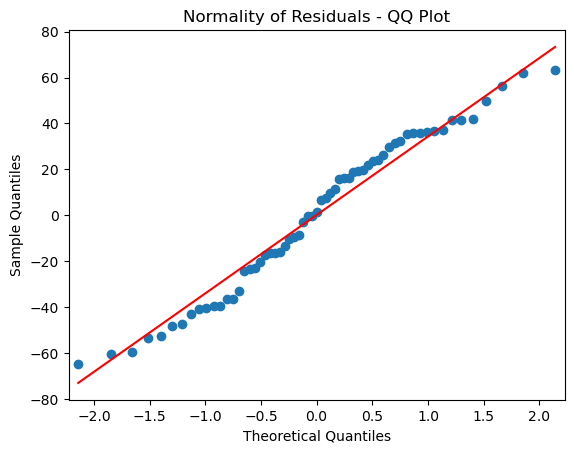

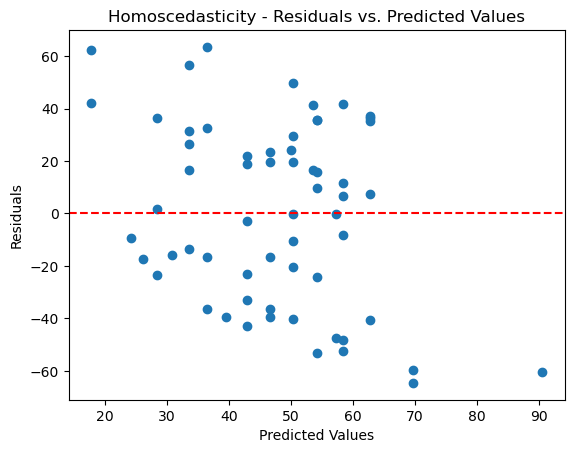

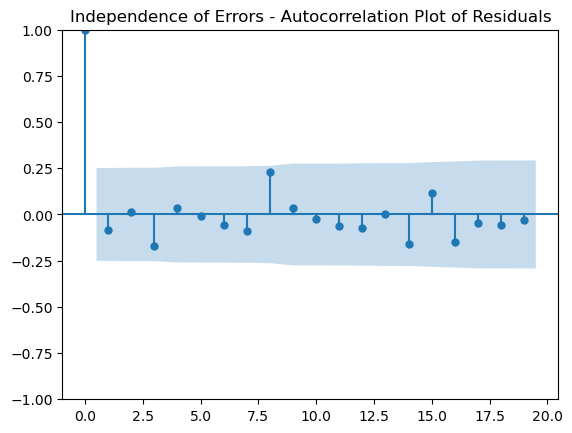

95% confidence interval for MSE: [ 889.81876614 1455.90476385]
95% confidence interval for MAE: [25.19524922 33.97548136]
95% confidence interval for R2: [-0.39300436  0.12952999]


In [75]:
# Load the dataset
data = pd.read_csv('new_data_fill_missing_linear&mode.csv')
data = data.drop(['programme',"Tijdstempel",'random_number','good_day_(1)',
                  'good_day_(2)','birthday','bed_time'], axis=1)

# Separate target variable and feature variables
target = data['stress_level']
data = data.drop(['stress_level'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# # Define column transformer to handle numerical features
# # Replace 'num_features' with the list of column names that represent numerical features in your dataset
cat_features = X_train[['course_ML', 'course_retrieval', 'course_statistics', 'course_databases', 'gender', 'ChatGPT', 'prev_answer_stand']]
scaler = MinMaxScaler()
cat_features = scaler.fit_transform(cat_features)
cat_features = scaler.transform(cat_features)

num_features = X_train[['sports_per_week', 'students_in_room']]

scaler = MinMaxScaler()
num_features = scaler.fit_transform(num_features)
num_features = scaler.transform(num_features)
# Split the dataset into training and testing sets

# # Scale the features


# Define the hyperparameters to be tuned
param_distributions = {
        'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
            'svr__gamma': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
     'select__k': [2, 3, 4]  # select the best 2, 3, or 4 features
}

# Scoring function for numerical features
score_func_num = f_regression

# Scoring function for categorical features
score_func_cat = f_classif

# Create SelectPercentile object for numerical features
select_num = SelectKBest(score_func=score_func_num,k=2)

# Create SelectPercentile object for categorical features
select_cat = SelectKBest(score_func=score_func_cat,k=3)

# Fit and transform numerical features
X_num_selected = select_num.fit_transform(num_features, y_train)

# Fit and transform categorical features
X_cat_selected = select_cat.fit_transform(cat_features, y_train)

# Concatenate or combine the selected features from both numerical and categorical features as needed
X_selected = np.concatenate((X_num_selected, X_cat_selected), axis=1)


# Create a pipeline to select the best features and train the SVR model
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_regression, k=3)),
    ('svr', SVR())
])

# Perform a randomized search to find the best hyperparameters
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42)
randomized_search.fit(X_train, y_train)


# Print the best hyperparameters and their corresponding MAE score
print("Best hyperparameters:", randomized_search.best_params_)
print("Mean absolute error:", -randomized_search.best_score_)

# Print the selected features and their p-values
selected_features = randomized_search.best_estimator_.named_steps['select'].get_support()
p_values = randomized_search.best_estimator_.named_steps['select'].pvalues_
feature_names = data.columns
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {selected_features[i]}, p-value: {p_values[i]}")

# Evaluate the performance on the test set using the best hyperparameters
y_pred = randomized_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test set mean absolute error:", mae)
print("Test set R-squared score:", r2)

# Calculate the confidence interval for the test set
n = len(y_test)
k = randomized_search.best_estimator_.named_steps['select'].k
y_mean = np.mean(y_test)
t_value = 1.96 # t-value for 95% confidence interval
y_pred_std = np.sqrt(mae)
ci_half_width = t_value * y_pred_std / np.sqrt(n-k-1)
ci_lower = y_mean - ci_half_width
ci_upper = y_mean + ci_half_width
print(f"95% confidence interval for test set predictions: [{ci_lower}, {ci_upper}]")

# # Plot the residuals
residuals = y_test - y_pred

# Check if the residuals are normally distributed
stat, p = shapiro(residuals)
print("Shapiro-Wilk test for normality of residuals:")
print("Statistic:", stat)
print("p-value:", p)
if p > 0.05:
    print("The residuals are likely normally distributed.")
else:
    print("The residuals are not normally distributed.")

# Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residuals plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Normality of residuals - QQ plot
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title('Normality of Residuals - QQ Plot')
plt.show()

# Homoscedasticity - Residuals vs. Predicted Values plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity - Residuals vs. Predicted Values')
plt.show()

# Independence of errors - Autocorrelation plot of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=19)
plt.title('Independence of Errors - Autocorrelation Plot of Residuals')
plt.show()

from sklearn.utils import resample

# Define function to calculate R-squared, MSE, and MAE
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Perform bootstrapping to calculate confidence intervals
n_bootstraps = 1000 # Number of bootstraps
mse_scores = []
mae_scores = []
r2_scores = []
for i in range(n_bootstraps):
    # Bootstrap the test set
    X_test_boot, y_test_boot = resample(X_test, y_test, random_state=i)
    
    # Make predictions on bootstrapped test set
    y_pred_boot = randomized_search.predict(X_test_boot)
    
    # Calculate metrics on bootstrapped test set
    mse_boot, mae_boot, r2_boot = calculate_metrics(y_test_boot, y_pred_boot)
    
    # Append scores to lists
    mse_scores.append(mse_boot)
    mae_scores.append(mae_boot)
    r2_scores.append(r2_boot)

# Calculate confidence intervals
alpha = 0.05 # Significance level
mse_ci = np.percentile(mse_scores, q=[alpha/2*100, (1-alpha/2)*100])
mae_ci = np.percentile(mae_scores, q=[alpha/2*100, (1-alpha/2)*100])
r2_ci = np.percentile(r2_scores, q=[alpha/2*100, (1-alpha/2)*100])

# Print confidence intervals
print("95% confidence interval for MSE:", mse_ci)
print("95% confidence interval for MAE:", mae_ci)
print("95% confidence interval for R2:", r2_ci)